## ddqc Tutorial
First, lets set up the workspace loading the ddqc and pegasus packages

In [1]:
import pegasus as pg
import ddqc

### Reading the data
For this tutorial we will use the Human Bone Marrow dataset provided by pegasus. <br>
We will download the dataset using the following command:

In [2]:
!curl https://storage.googleapis.com/terra-featured-workspaces/Cumulus/MantonBM_nonmix_subset.zarr.zip -o MantonBM_nonmix_subset.zarr.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 78.1M  100 78.1M    0     0  33.4M      0  0:00:02  0:00:02 --:--:-- 33.4M


We will first load the data using the standard `read_input` pegasus function.

In [3]:
data = pg.read_input("MantonBM_nonmix_subset.zarr.zip")
data

2022-05-31 04:11:24,994 - pegasusio.readwrite - INFO - zarr file 'MantonBM_nonmix_subset.zarr.zip' is loaded.
2022-05-31 04:11:24,995 - pegasusio.readwrite - INFO - Function 'read_input' finished in 0.33s.


MultimodalData object with 1 UnimodalData: 'GRCh38-rna'
    It currently binds to UnimodalData object GRCh38-rna

UnimodalData object with n_obs x n_vars = 48219 x 36601
    Genome: GRCh38; Modality: rna
    It contains 1 matrix: 'X'
    It currently binds to matrix 'X' as X

    obs: 'n_genes', 'Channel', 'gender'
    var: 'featureid'
    uns: 'genome', 'modality'

### Biology-centered data-driven quality control (ddqc)
ddqc does adaptive quality control by clustering cells and picking a separate threshold for each cluster. It is described down below:
- Initial Qualtity Control (QC) is performed, when obvious low-quality cells are removed. By default those are cells with n_genes < 100 and percent_mito > 80.
- The cells are clustered with the clustering resolution 1.3 (default)
- Then thesholds are picked for each cluster. By default the following metrics are considered:
    - **Number of counts/UMIs**: keep cells that have n_counts greater than median - 2 Median Absolute Deviations (MAD)
    - **Number of genes**: keep cells that have n_genes greater than median - 2 MADs
    - **Percent of mitochondrial transctipts**: keep cells that have percent_mito less than median + 2 MADs
- In order to prevent the removal of healthy cells in clusters with high median n_genes and low percent_mito there are additional bounds for those thresholds:
    - Cluster-level threshold for n_genes can't be greater than 200 (default). If it is greater, it will be set to 200.
    - Cluster-level threshold for percent_mito can't be lower than 10 (default). If it is lower, it will be set to 10.

To perform ddqc on a dataset, we will run the `ddqc_metrics` function. 

If you want to customize the filtering you can use the following parameters:
- `res` (float): clustering resolution (default is 1.3).
- `clustering_method` (str): clustering method that will be used by ddqc clustering. Supported options are:
    "louvain", "leiden", "spectral_louvain", and "spectral_leiden" (default is "louvain").
- `n_components` (int): number of PCA components (default is 50).
- `k` (int): k to be used by `neighbors` Pegasus function (default is 20).
- `method` (str): statistic on which the threshold would be calculated. Supported options are "mad" and "outlier"
    (default is "mad").
- `threshold` (float): parameter for the selected method (default is 2).
    Note that "outlier" method doesn't requre parameter and will ignore this option.
- `threshold_counts` (int, None): setting for applying ddqc based on number of counts. (Default is 0)
    - If set to 0, will perform ddqc on number of counts using the `threshold` parameter provided earlier.
    - If set to a number other than 0, will  overwrite `threshold` parameter for number of counts.
    - If set to None, won't perform ddqc on number of counts.
- `threshold_genes` (int, None): Same as above, but for number of genes.
- `threshold_mito` (float, None): Same as above, but for percent of mitochondrial transcripts.
- `threshold_ribo` (float, None): Same as above, but for percent of ribosomal transcripts.
- `basic_n_genes` (int): parameter for the initial QC n_genes filtering (default is 100).
- `basic_percent_mito` (float): parameter for the initial QC percent_mito filtering (default is 80.0).
- `mito_prefix` (str): gene prefix used to calculate percent_mito in a cell (default is "MT-").
- `ribo_prefix` (str): gene regular expression used to calculate percent_ribo in a cell
    (default is "^RP[SL][[:digit:]]|^RPLP[[:digit:]]|^RPSA").
- `n_genes_lower_bound` (int): bound for lower n_genes cluster-level threshold (default is 200).
- `percent_mito_upper_bound` (float): bound for upper percent_mito cluster-level threshold (default is 10).
- `random_state` (int): random seed for clustering results reproducibility (default is 29)
- `return_df_qc` (bool): whether to return a dataframe with the information about on what metric and what threshold
    the cell was removed for each removed cell. (default is False)
- `display_plots` (bool): whether to show plots that would show filtering statistics (default is True).

We will now run ddqc on the dataset with default settings.

/home/unix/malperov/pegasusenv/lib/python3.8/site-packages/ddqc/utils.py:18: FutureWarning: Possible nested set at position 8
  data.var_names.map(lambda x: re.match(ribo_prefix, x, flags=re.IGNORECASE) is not None).values.nonzero()[
/home/unix/malperov/pegasusenv/lib/python3.8/site-packages/ddqc/utils.py:18: FutureWarning: Possible nested set at position 25
  data.var_names.map(lambda x: re.match(ribo_prefix, x, flags=re.IGNORECASE) is not None).values.nonzero()[


2022-05-31 04:11:26,131 - pegasusio.qc_utils - INFO - After filtration, 48210 out of 48219 cell barcodes are kept in UnimodalData object GRCh38-rna.
2022-05-31 04:11:26,132 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.38s.
2022-05-31 04:11:26,896 - pegasus.tools.preprocessing - INFO - After filtration, 25910/36601 genes are kept. Among 25910 genes, 16967 genes are robust.
2022-05-31 04:11:26,898 - pegasus.tools.preprocessing - INFO - Function 'identify_robust_genes' finished in 0.76s.
2022-05-31 04:11:28,014 - pegasus.tools.preprocessing - INFO - Function 'log_norm' finished in 1.11s.
2022-05-31 04:11:28,142 - pegasus.tools.hvf_selection - INFO - Function 'estimate_feature_statistics' finished in 0.13s.
2022-05-31 04:11:28,202 - pegasus.tools.hvf_selection - INFO - 2000 highly variable features have been selected.
2022-05-31 04:11:28,203 - pegasus.tools.hvf_selection - INFO - Function 'highly_variable_features' finished in 0.19s.
2022-05-31 04:12:11,730 -

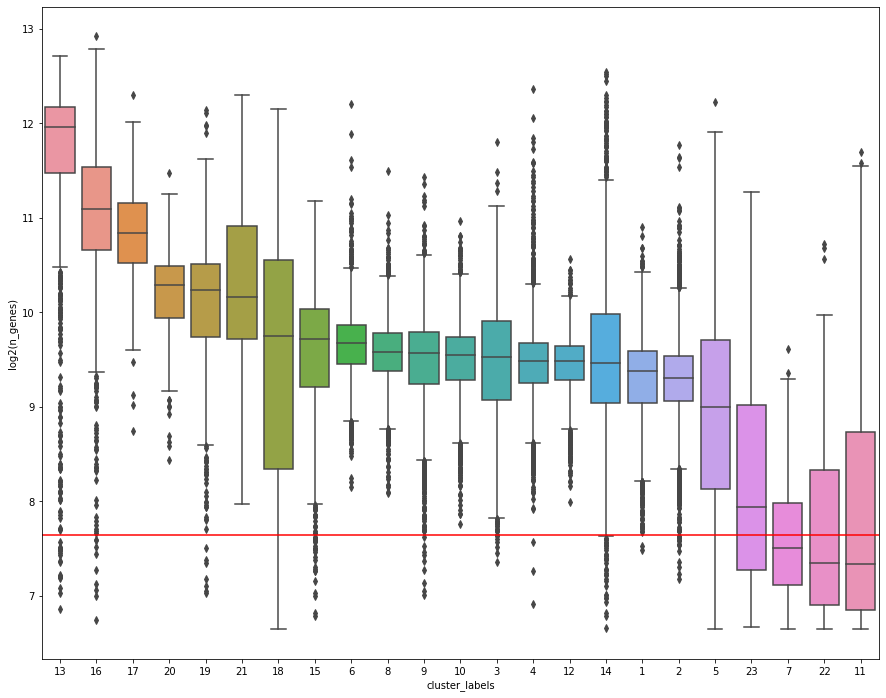

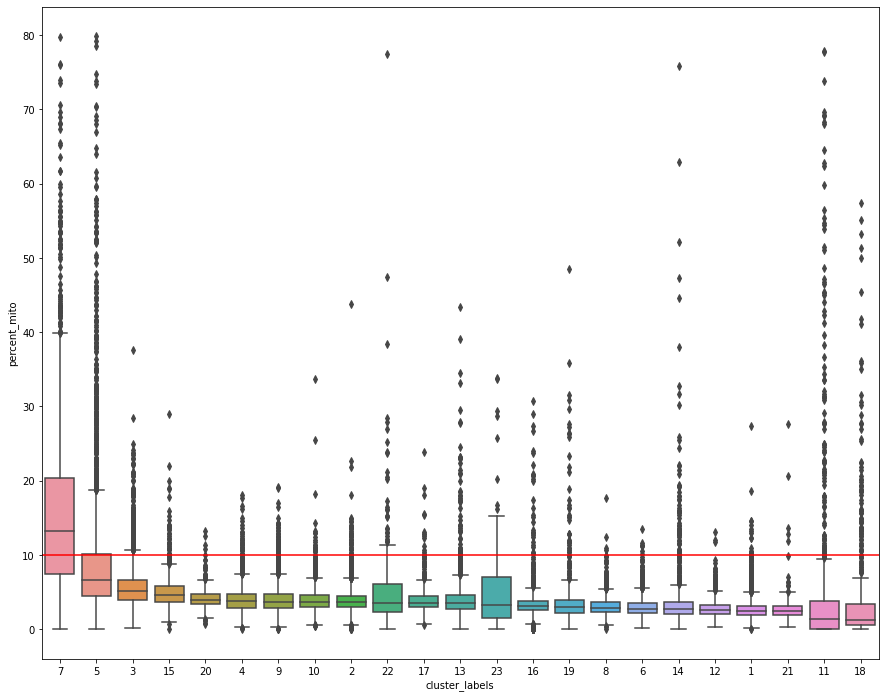

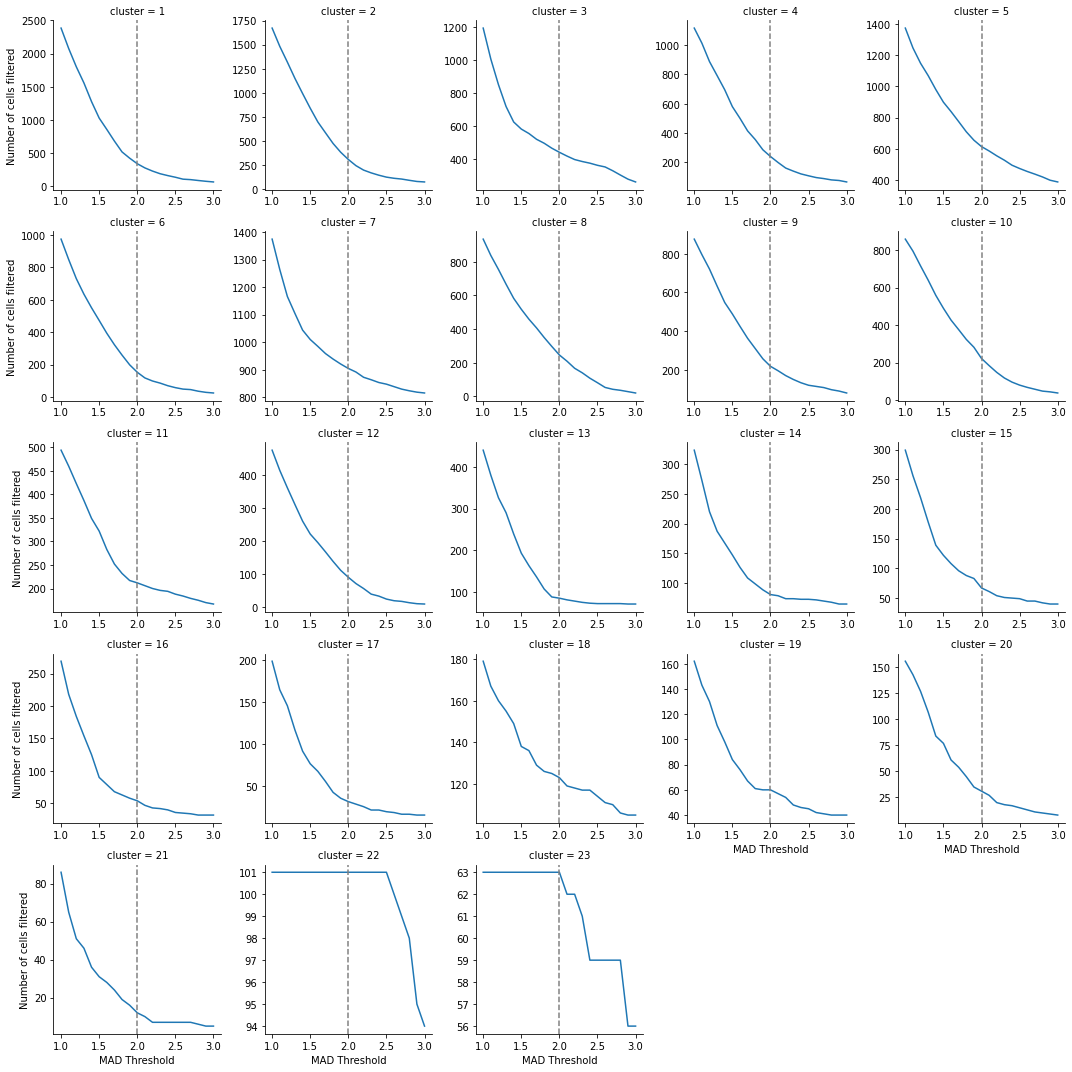

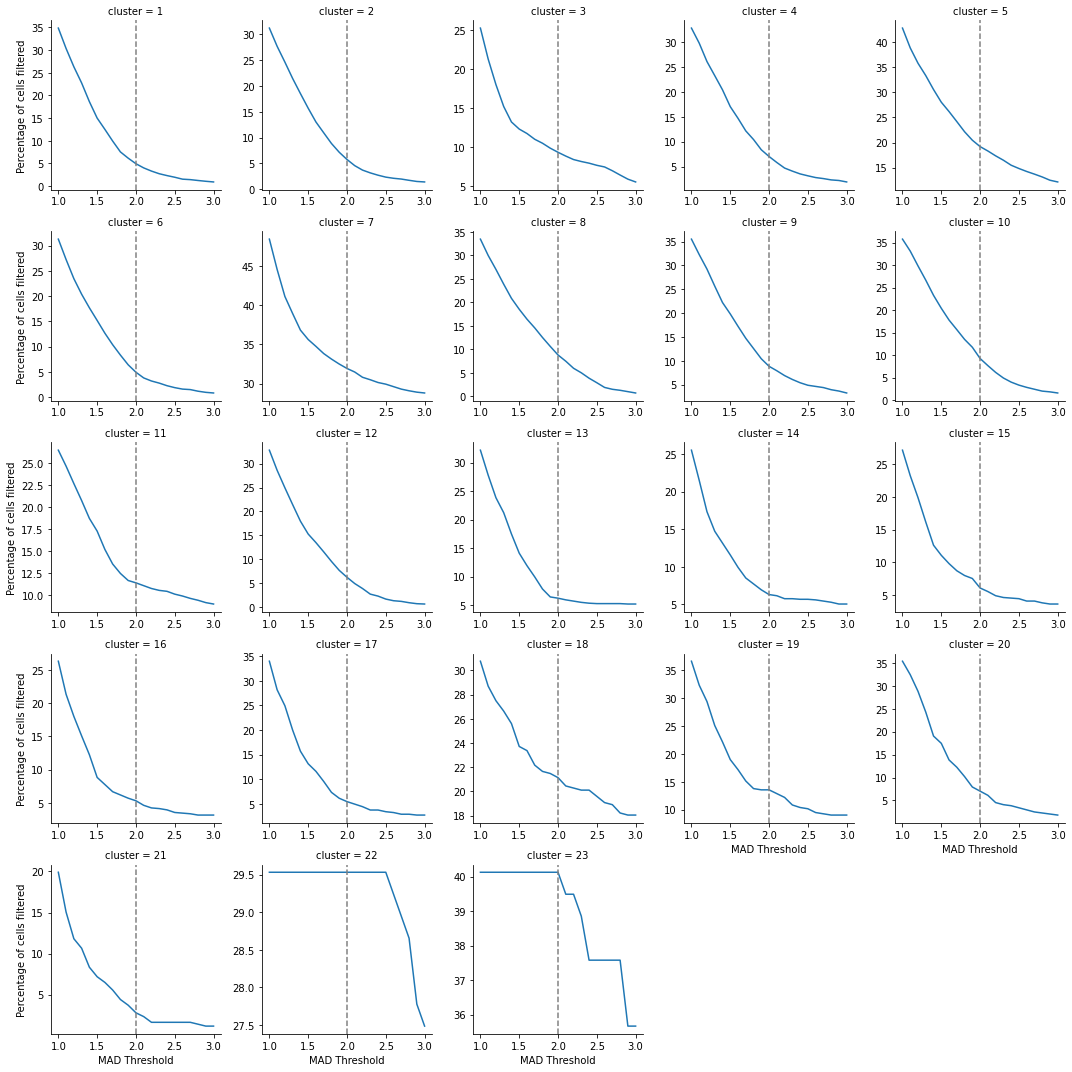

In [4]:
df_qc = ddqc.ddqc_metrics(data, return_df_qc=True)

### Disabling Initial QC
If want to use a separate QC tool instead of inital QC, such as EmptyDrops, you can disable Initial QC. Use the parameter settins outlined below (you can use these alongside any other customization parameters):

`df_qc = ddqc.ddqc_metrics(data, basic_n_genes=0, basic_percent_mito=100)`

### Outputs
There are two boxplots provided for exploratory data analysis:
- log2(n_genes) by cluster: shows log2 of number of genes for each cluster in the initial clustering. Red line at 200 genes (7.64 in log2 scale) represents the most common fixed threshold cutoff for n_genes.
- percent_mito by cluster: shows percent_mito for each cluster in the initial clustering. Red line at 10% represents the most common fixed threshold cutoff for percent_mito.


Also, if you are using "mad" method and didn't use any of metric threshold overwrites (threshold_counts, threshold_genes, threshold_mito, threshold_ribo), ddqc will generate two facet plots that show how number of cells that are filtered out changes depending on the threshold value. These plots will help you to pick a threshold parameter if you want to tune it.

Each of those plots is faceted by cluster, and has a threshold parameter (from 1 to 3) on x-axis. First plot will have a number of cells filtered out in cluster on y-axis, second plot will have a percentage of cells filtered out in cluster.

The filtering will still be performed based on the threshold you picked.

If you requested to return df_qc the function will return a pandas dataframe containing the following info for each cell:
- `metric`: QC metric number
- `cluster_labels`: cluster from initial clustering performed by ddqc
- `metric_lower_co` and `metric_upper_co`: lower and upper cuttofs for each metric on which ddqc was performed. If ddqc was not performed for upper or lower end of this metric this field will be `None`
- `metric.passed.qc`: whether the cell passed qc for a given metric
This information is useful if you want to understand based on which metric the cell was filtered out.

In [5]:
df_qc

,cluster_labels,n_counts_lower_co,n_counts_upper_co,n_counts,n_counts_passed_qc,n_genes_lower_co,n_genes_upper_co,n_genes,n_genes_passed_qc,percent_mito_lower_co,percent_mito_upper_co,percent_mito,percent_mito_passed_qc,percent_ribo_lower_co,percent_ribo_upper_co,percent_ribo,percent_ribo_passed_qc,passed_qc
barcodekey,,,,,,,,,,,,,,,,,,
MantonBM1_HiSeq_1-AAACCTGAGCAGGTCA,8,1511.0264,None,3554.0,True,200,None,816.0,True,None,10.0,3.967361,True,None,0.545193,0.309510,True,True
MantonBM1_HiSeq_1-AAACCTGCACACTGCG,3,-433.6124,None,1740.0,True,119.2384,None,716.0,True,None,10.0,6.034483,True,None,0.222514,0.057471,True,True
MantonBM1_HiSeq_1-AAACCTGCACCGGAAA,1,609.7802,None,2435.0,True,200,None,554.0,True,None,10.0,2.751540,True,None,0.551692,0.574949,False,False
MantonBM1_HiSeq_1-AAACCTGCATAGACTC,4,726.5464,None,2913.0,True,200,None,967.0,True,None,10.0,3.329900,True,None,0.447078,0.171644,True,True
MantonBM1_HiSeq_1-AAACCTGCATCGATGT,14,-329.054,None,5372.0,True,76.3602,None,1704.0,True,None,10.0,2.122115,True,None,0.474398,0.428146,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MantonBM8_HiSeq_1-TTTGTCAGTCCGACGT,1,609.7802,None,1570.0,True,200,None,454.0,True,None,10.0,3.566879,True,None,0.551692,0.254777,True,True
MantonBM8_HiSeq_1-TTTGTCAGTCGCGGTT,3,-433.6124,None,1367.0,True,119.2384,None,539.0,True,None,10.0,7.388442,True,None,0.222514,0.073153,True,True
MantonBM8_HiSeq_1-TTTGTCAGTGGTGTAG,3,-433.6124,None,3834.0,True,119.2384,None,1117.0,True,None,10.0,2.973396,True,None,0.222514,0.104330,True,True


### Filter out the cells
Now, we will filter out the cells that failed ddqc. Here, we started with 48219 cells and retain 45939 cells.

In [6]:
pg.filter_data(data)

2022-05-31 04:13:31,471 - pegasusio.qc_utils - INFO - After filtration, 43517 out of 48210 cell barcodes are kept in UnimodalData object GRCh38-rna.
2022-05-31 04:13:31,473 - pegasus.tools.preprocessing - INFO - Function 'filter_data' finished in 0.41s.


### Save the dataset
We will save the dataset as data.h5ad, which can then be imported into the scRNAseq pipeline of your choice for downstream analysis.

In [7]:
pg.write_output(data, "data.h5ad")

2022-05-31 04:13:44,390 - pegasusio.readwrite - INFO - h5ad file 'data.h5ad' is written.
2022-05-31 04:13:44,391 - pegasusio.readwrite - INFO - Function 'write_output' finished in 12.91s.
